## Oscilador de Van der Pol (não-linear)
Vamos considerar o oscilador de Van der Pol, que descreve, por exemplo, um circuito com um díodo. A equação de movimento, escalada, tem a forma:
$$
\frac{\partial^2 x}{\partial t^2} + \epsilon(x^2-1)\frac{\partial x}{\partial t} + x = 0.
$$
em que $ \epsilon$ é um parâmetro positivo. Repare-se que o termo em $ \epsilon$ representa uma espécie de perda/ganho consoante $x$ é menor ou maior que 1, respectivamente. Assim é de esperar que as soluções convirjam para oscilações de amplitude unitária.

Vamos usar um programa de integração de valores iniciais, com o método Runge-Kutta de 4ª ordem (RK4). Podíamos igualmente usar (com vantagem!) um método do scipy.integrate.odeint (que tem passo adaptativo). Mas como tinha este feito, serve para o efeito.


In [1]:
# -*- coding: iso-8859-1 -*-
'''exemplos do método de Runge-Kutta de 4ªordem  para integração de ODE.
As funções derivadas são as correspondentes ao oscilador de van der Pol'''
#
#from numpy import zeros, arange, dot, array, pi, transpose
from pylab import  figure,  plot, show
from numpy import fft
import numpy as np
import matplotlib.pyplot as plt

def rk4(f,y0,t,h):
    k1 = h*f(y0,t)
    k2 = h*f(y0+k1/2., t+h/2.)
    k3 = h*f(y0+k2/2., t+h/2.)
    k4 = h*f(y0+k3, t+h)
    y = y0 + k1/6. + k2/3.+ k3/3. + k4/6.
    return y

def rk4_driver(f,y0,ti,tf,N):   # this form to integrate a single first order ODE
    h = (tf-ti)/N
    ya = copy(y0)
    for ii in range(N):
        y = rk4(f,ya,t,h)
        t = t + h
        ya = y
    return y

def rk4_driv1(f,y0,ti,tf,N):     # this form to integrate a vector, like when we have system of equations
    y = np.zeros((N+1, len(y0)),float)
    tt = np.zeros((N+1),float)
    h = (tf-ti)/N
    y[0] = y0
    tt[0] = ti
    for ii in range(N):
        y[ii+1] = rk4(f,y[ii],tt[ii],h)
        tt[ii+1] = tt[ii] + h
    return y,tt
    
def ode(y,t):       # oscilador de Van der Pol
    dydt = np.zeros(len(y),float)
    dydt[0] = y[1]
    dydt[1] = -y[0] - eps*(y[0]**2 -1)*y[1]
    return dydt



Como todos os osciladores, teremos inicialmente transientes. Assim vamos deixar evoluir por algum tempo até atingir o "estado estacionário". Depois estudamos oscilações daí em diante, durante um determinado intervalo de tempo.

[0. 1.]


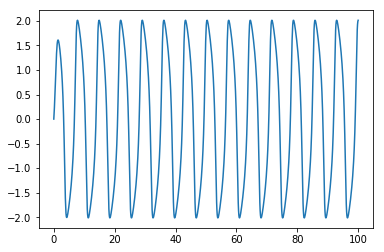

[2.01379298 0.08028291]


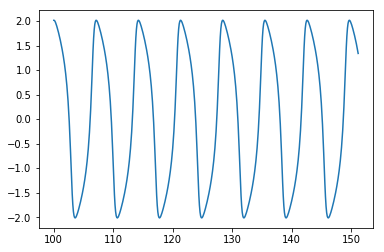

In [5]:
eps   = 1.5   # parâmetro
t0    = 0.    # instante inicial
t_buf = 100.  # instante final do bi«uffer
Nb    = 1000  # número de pontos para guardar valores

y0 = np.array((0, 1), float)  # condições iniciais (posição,velocidade)
print(y0)
[func, time] = rk4_driv1(ode, y0, t0, t_buf, Nb)
figure(1)
plot(time, func[:, 0])
show()
# Agora vamos prosseguir, guardando os valores a analisar
del_t = 0.1 #0.208231       # passo de amostragem
N     = 512       # número de pontos para guardar valores
t_i   = t_buf     # instante inicial (é o fim do buffer)
t_f   = t_i + N*del_t  # instante final, correspondente a avançar N passos del_t.

y02    = func[Nb,:]    # condições iniciais, correspondentes ao estado do sistema no final do buffer
print(y02)
[func_f, t] = rk4_driv1(ode, y02, t_i, t_f, N)
plot(t, func_f[:, 0])
show()
signal  = func_f[:,0]

Claramente não temos oscilações harmónicas. A razão é que a não-linearidade gera e mistura componentes, a partir do fundamental. Que harmónicos estarão presentes? Vamos estudar o sistema no domínio das frequências. Para tal usamos a FFT.

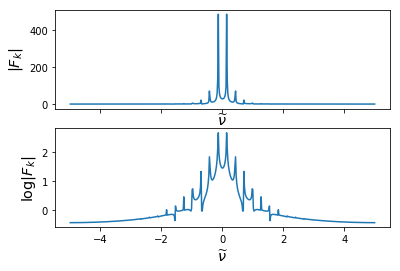

In [6]:
# Agora queremos analisar o espectro.

FFT   = abs(fft.fft(signal))
freqs = fft.fftfreq(signal.size, t[1]-t[0])
FFT   = fft.fftshift(FFT)    # Shift  freq zero para o centro
freqs = fft.fftshift(freqs)    # Shift freq zero para o centro
#plt.figure()
f, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(freqs, np.absolute(FFT))  # Plot  amplitude espectral
ax[0].set_ylabel(r'$\vert F_k\vert$', size = 'x-large')
ax[0].set_xlabel(r'$\widetilde{\nu}$', size = 'x-large')
ax[1].plot(freqs,np.log10(np.absolute(FFT))) # Plot  amplitude espectral em escala semi-log
ax[1].set_ylabel(r'$\log\vert F_k\vert$', size = 'x-large')
ax[1].set_xlabel(r'$\widetilde{\nu}$', size = 'x-large')
show()

Aumentar a resolução: aumentamos del_t ou N.
A frequência de Nyquist para del_t = 0.1 é $f_N = 31.416 s^{-1}$, logo podemos aumentar del_t para 0.2.

A observação do plot do sinal mostra que não temos um número completo de oscilações no intervalo escolhido. Ora o algoritmo FFT assume que temos uma função periódica. Assim vamos procurar obter um sinal periódico. Para isso fazemos a janela um múltiplo inteiro de períodos. Qual o período? Do gráfico do espectro vemos que o fundamental é $f_0\approx 0.14 s^{-1}$, logo $T\approx 1/f_0$. Se escolhermos ter 16 períodos inteiros na janela, teremos $\Delta t= 16T$ e se mantivermos $N=512$, virá $\delta t = 16*T/N = 16/f_0 = 0.208231$.